In [25]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random, device_put

import numpy as np
import matplotlib.pyplot as plt

from aaa import *

In [26]:
# Jit and vectorize the functions

jax_cdf_differential_decay_width_jit = jit(jax_cdf_differential_decay_width)
jax_cdf_norm_jit = jit(jax_cdf_norm)

jax_cdf_differential_decay_width_vmap_final_energy = vmap(jax_cdf_differential_decay_width_jit, in_axes=(None, 0, None, None, None), out_axes=0)
jax_cdf_differential_decay_width_vmap = vmap(jax_cdf_differential_decay_width_vmap_final_energy, in_axes=(None, None, 0, None, None), out_axes=1)
jax_cdf_norm_vmap = vmap(jax_cdf_norm_jit, in_axes=(0, None, None), out_axes=0)

In [49]:
# Get the gradients

grad_cdf_differential_decay_width = grad(jax_cdf_differential_decay_width, argnums=(1, 4))
grad_cdf_norm = grad(jax_cdf_norm, argnums=(0, 2))
grad_total_decay_width_to_discrete = grad(jax_total_decay_width_to_discrete, argnums=(0))

grad_continuum_cut = grad(jax_continuum_cut, argnums=(0, 1, 3))
grad2_continuum_cut = grad(grad_continuum_cut, argnums=(0, 1, 3))

# Define the gradient calculator for \nabla_{\theta}
def grad_theta_x(cdf_norm, final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter):
    gradv = grad_cdf_differential_decay_width(cdf_norm, final_energy, initial_energy, discrete_continuum_boundary, disp_parameter)
    
    grad_x_cdf = gradv[0] # --> this is just the PDF!
    grad_theta_cdf = gradv[1]

    eps = 1e-4
    #print("CDF", cdf_norm)
    cdf_norm_a = jax_cdf_norm(initial_energy, discrete_continuum_boundary, disp_parameter + eps)
    cdf_norm_b = jax_cdf_norm(initial_energy, discrete_continuum_boundary, disp_parameter - eps)
    
    a = jax_cdf_differential_decay_width(cdf_norm_a, final_energy, initial_energy, discrete_continuum_boundary, disp_parameter + eps)
    b = jax_cdf_differential_decay_width(cdf_norm_b, final_energy, initial_energy, discrete_continuum_boundary, disp_parameter - eps)
    grad_theta_cdf_fd = (a - b) / (2 * eps)
    print(grad_theta_cdf, grad_theta_cdf_fd, "SALDJD")
    print(b, cdf_differential_decay_width(final_energy, initial_energy, discrete_continuum_boundary, disp_parameter - eps), "vals")

    # We need to correct for the "spicy" factor in the inverse CDF.
    continuum_boundary = jax_continuum_cut(initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)

    grad_theta_x = - grad_theta_cdf / grad_x_cdf * continuum_boundary

    return grad_theta_x

grad2_theta_x = grad(grad_theta_x, argnums=(1, 2, 4, 5))

In [50]:
start_energy = 23.0
final_energy = 15.0
disp_parameter = 0.01
discrete_continuum_boundary = DISCRETE_CONTINUUM_BOUNDARY
cdf_norm = jax_cdf_norm_vmap(jnp.array([start_energy]), discrete_continuum_boundary, disp_parameter)[0]
#print(cdf_norm)

cdf = jax_cdf_differential_decay_width_vmap(cdf_norm, jnp.array([final_energy]), jnp.array([start_energy]), discrete_continuum_boundary, disp_parameter)
print(cdf[0,0])

gradv = grad_theta_x(cdf_norm, final_energy, start_energy, DISCRETE_ENERGIES, discrete_continuum_boundary, disp_parameter)
print(gradv)

0.73846024
62.448055 10.1161 SALDJD
0.737443 0.7374428764949678 vals
-126.41198


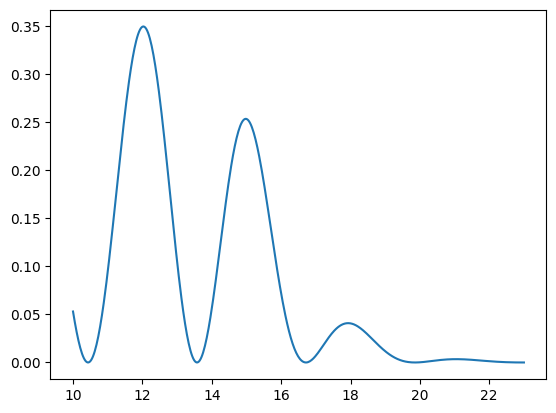

In [6]:
final_energies = jnp.linspace(10.0, 23.0, 500)

grads = []
cdfs = []

for i, ef in enumerate(final_energies):
    cdf = jax_cdf_differential_decay_width_vmap(cdf_norm, jnp.array([ef]), jnp.array([start_energy]), discrete_continuum_boundary, disp_parameter)
    grad = grad_cdf_differential_decay_width(cdf_norm, ef, start_energy, discrete_continuum_boundary, disp_parameter)[0]
    
    grads.append(grad)
    cdfs.append(cdf[0,0])

plt.plot(final_energies, grads)

# ddw_norm = jnp.trapz(differential_decay_width(final_energies, start_energy, discrete_continuum_boundary, disp_parameter), final_energies)
# plt.plot(final_energies, differential_decay_width(final_energies, start_energy, discrete_continuum_boundary, disp_parameter)/ddw_norm)

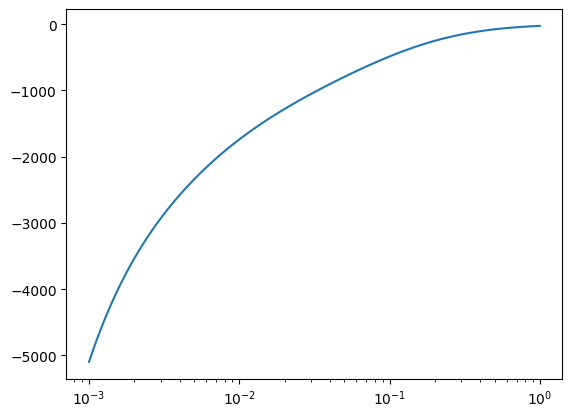

In [ ]:
disp_parameters = jnp.logspace(-3, 0, 100)
start_energy = 23.0
final_energy = 18.0

grads = []
grads_theta = []
grads_x = []
cdfs = []

for i, dp in enumerate(disp_parameters):
    cdf = jax_cdf_differential_decay_width_vmap(cdf_norm, jnp.array([final_energy]), jnp.array([start_energy]), discrete_continuum_boundary, dp)
    #grad = grad_cdf_differential_decay_width(cdf_norm, ef, start_energy, discrete_continuum_boundary, dp)[1]
    grad, grad_x, grad_theta = grad_theta_x(cdf_norm, final_energy, start_energy, discrete_continuum_boundary, dp)
    
    grads.append(grad)
    grads_x.append(grad_x)
    grads_theta.append(grad_theta)
    cdfs.append(cdf[0,0])

plt.plot(disp_parameters, grads)
#plt.plot(disp_parameters, grads_x)
plt.xscale('log')
#plt.yscale('log')

In [ ]:
def continuum_circuit(initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter):
    energy_path = [initial_energy]
    continuum_cuts = []
    prev_energy = initial_energy

    while True:
        # Sample the next energy
        r = np.random.rand()
        next_energy, continuum_cut = spicy_inverse_cdf_differential_decay_width(
                                                                r, prev_energy, discrete_energies,
                                                                discrete_continuum_boundary,
                                                                disp_parameter)
        
        continuum_cuts.append(continuum_cut)

        if next_energy < 0:
            break

        energy_path.append(next_energy)
        prev_energy = next_energy

    return energy_path, continuum_cuts


In [ ]:
discrete_energies = DISCRETE_ENERGIES
discrete_continuum_boundary = DISCRETE_CONTINUUM_BOUNDARY

continuum_energy_path, continuum_cuts = continuum_circuit(23.0, discrete_energies, discrete_continuum_boundary, 0.01)

print(continuum_energy_path)
print(continuum_cuts)

[23.0, 15.696563311828516, 11.118422708325896]
[Array(0.5125063, dtype=float32), Array(0.60037804, dtype=float32), Array(0.08838963, dtype=float32)]


Text(0.05, 23.0, 'E$_i$')

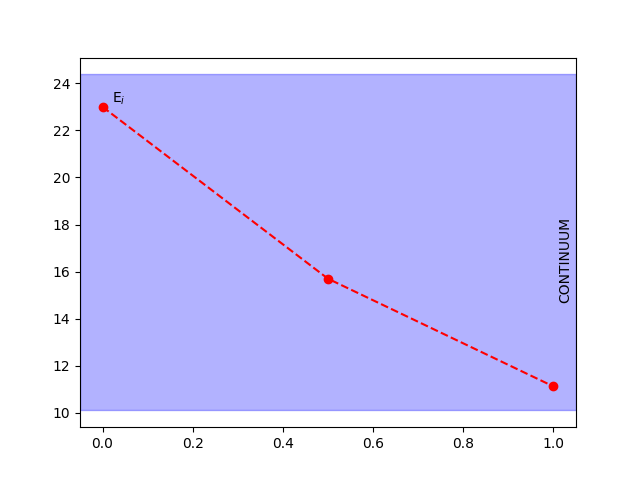

In [ ]:
%matplotlib widget
plt.figure()
# Plot the continuum energy range (from discrete/continuum boundary to start energy) as a rectangle
plt.axhspan(discrete_continuum_boundary * 1.01, start_energy * 1.06, alpha=0.3, color='blue')
# Add a "CONTINUUM" label to the right, rotated 90 degrees
plt.text(1.01, (discrete_continuum_boundary + start_energy)/2, 'CONTINUUM', rotation=90, verticalalignment='center', horizontalalignment='left')

# Plot the continuum energy path as a scatter joined with dashed lines
plt.plot(np.linspace(0, 1, len(continuum_energy_path)), continuum_energy_path, color='red', linestyle='--', marker='o')

# Add a label for the initial energy
plt.text(0.05, start_energy, r'E$_i$', verticalalignment='bottom', horizontalalignment='right')

In [55]:
# Let's try and "move" an event
initial_energy = 23.0
discrete_energies = DISCRETE_ENERGIES
discrete_continuum_boundary = DISCRETE_CONTINUUM_BOUNDARY
disp_parameter = 0.01

epsilon = 1e-5

# Sample an event and compute the gradients w.r.t. the disp_parameter
r = 0.4
next_energy, continuum_cut = spicy_inverse_cdf_differential_decay_width(
                                                    r, initial_energy, discrete_energies,
                                                    discrete_continuum_boundary,
                                                    disp_parameter)

print(disp_parameter, next_energy, continuum_cut)

cdf_norm = jax_cdf_norm(initial_energy, discrete_continuum_boundary, disp_parameter)
grad_thx = grad_theta_x(cdf_norm, next_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
grad_cb = grad_continuum_cut(initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)[-1]
print(grad_thx, grad_cb, "grads")

# "Move the event" by epsilon
moved_disp_parameter = disp_parameter + epsilon
moved_energy = next_energy + epsilon * grad_thx
moved_continuum_cut = continuum_cut + epsilon * grad_cb
print("Moved")
print(moved_energy, moved_continuum_cut)

# Now sample the event again at the new value of the disp_parameter
recomp_energy, recomp_continuum_cut = spicy_inverse_cdf_differential_decay_width(
                                                    r, initial_energy, discrete_energies,
                                                    discrete_continuum_boundary,
                                                    moved_disp_parameter)
print("Recomputed")
print(recomp_energy, recomp_continuum_cut)

0.01 15.168338177118141 0.5125063
64.52155 9.212196 SALDJD
0.7795515 0.7795515216405081 vals
-135.80994 17.705313 grads
Moved
15.16698 0.51268333
Recomputed
15.166853720017503 0.5126833
